<a href="https://colab.research.google.com/github/stephanie0620/DeepGenerativeModels/blob/main/WEEK2_GradCAM_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
使用CNN
"""
%matplotlib inline
import matplotlib.image as mpimg
import cv2
import numpy as np
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
from keras.models import Model
from keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
class HParam:
    batch_size = 128
    num_classes = 10
    epochs = 1

hp = HParam()

In [ ]:
# 載入資料集並預處理
(x_train, y_train), (x_test, y_test) = mnist.load_data()

nrow, ncol = 28, 28
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, nrow, ncol)
    x_test = x_test.reshape(x_test.shape[0], 1, nrow, ncol)
    input_shape = (1, nrow, ncol)
else:
    x_train = x_train.reshape(x_train.shape[0], nrow, ncol, 1)
    x_test = x_test.reshape(x_test.shape[0], nrow, ncol, 1)
    input_shape = (nrow, ncol, 1)
# Change variable type, value range
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# Convert classes into one-hot vector
y_train = keras.utils.to_categorical(y_train, hp.num_classes)
y_test = keras.utils.to_categorical(y_test, hp.num_classes)

# CNN模型
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

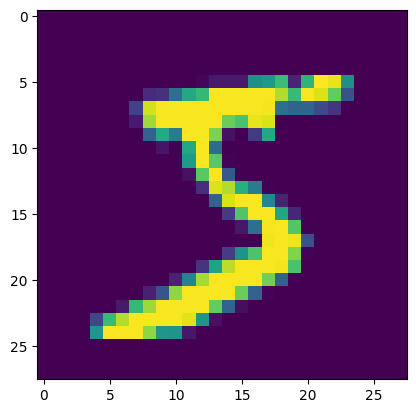

In [ ]:
x_train = x_train.squeeze()
test_img = x_train[0]
plt.imshow(test_img)

In [ ]:
x_train[0].max()

1.0

In [ ]:
# Extract the outputs of the two conv layers
layer_outputs = [layer.output for layer in model.layers[1:3]]
# Create a model returning the layer_outputs for the model input
act_model = Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2_input (InputLayer  [(None, 28, 28, 1)]       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
Total params: 18816 (73.50 KB)
Trainable params: 18816 (73.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
activations = act_model.predict(test_img.reshape(1,test_img.shape[0],test_img.shape[1],1))

[print(act.shape) for act in activations];

(1, 13, 13, 32)
(1, 11, 11, 64)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


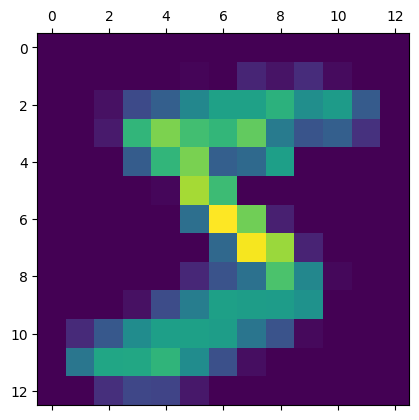

In [ ]:
plt.matshow(activations[0][0,:,:,31], cmap='viridis')

In [ ]:
# Make grid plots
def plot_conv_layer(which_conv):
    # Plot conv layer activation
    # which_conv = 0 # 0=first, 1=second
    img_per_row = 10
    n_feat = activations[which_conv].shape[-1] # number of feature maps
    size = activations[which_conv].shape[1] # image feature (e.g., 26)
    n_col = np.round(n_feat/img_per_row).astype('int')
    display_grid = np.zeros((size*n_col, img_per_row*size))
    # Add each filter into the grids
    for col in range(n_col):
        for row in range(img_per_row):
            if col*img_per_row+row < size:
                img = activations[which_conv][0,:,:,col*img_per_row+row]
                # Post-process images
                img -= img.mean()
                img -= img.std()
                img *= 64
                img += 128
                img = np.clip(img, 0, 255).astype('uint8')
                display_grid[col*size:(col+1)*size,
                             row*size:(row+1)*size] = img
    scale = 1/size
    fig, ax = plt.subplots(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    ax.set_title(f'ConvLayer = {which_conv+1}')
    ax.grid(False)
    ax.imshow(display_grid, aspect='auto', cmap='viridis')
    return fig, ax

(<Figure size 1000x300 with 1 Axes>, <Axes: title={'center': 'ConvLayer = 1'}>)

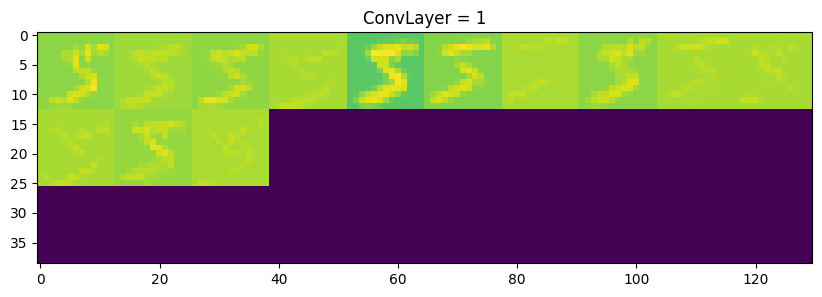

In [ ]:
plot_conv_layer(0)

(<Figure size 1000x600 with 1 Axes>, <Axes: title={'center': 'ConvLayer = 2'}>)

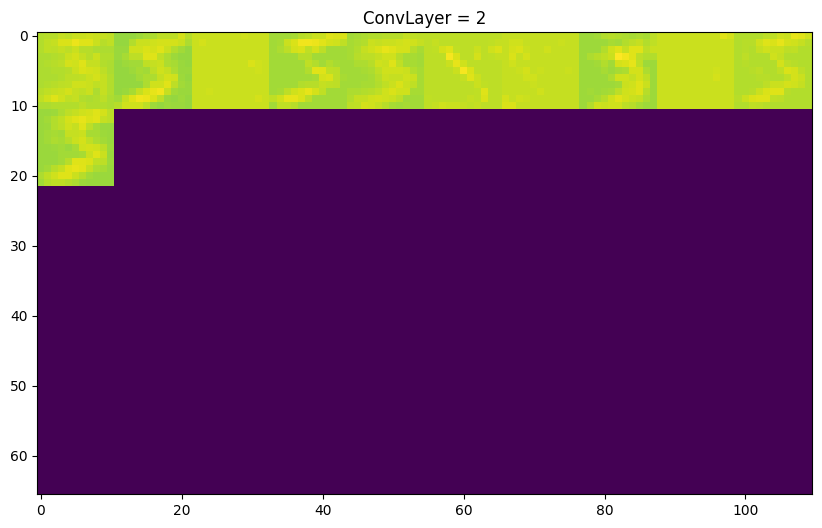

In [ ]:
plot_conv_layer(1)

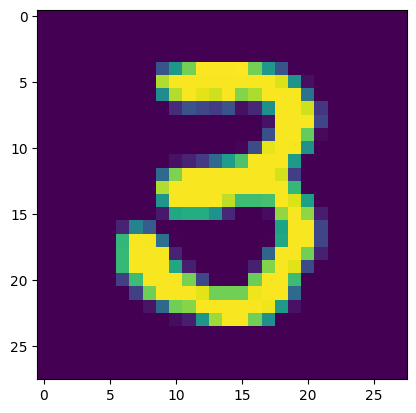

In [ ]:
which_number = 3
# Convert ont-hot vector to integer
y_test_int = np.where(y_test==1)[1]
# Randomly select one example
rand_idx = np.random.choice(np.where(y_test_int == which_number)[0])
test_input = x_test[rand_idx].reshape(1,x_test.shape[1],x_test.shape[2],1)
# Visualize test_input
plt.imshow(test_input.squeeze());

In [ ]:
# Get output vector
output_vector = model.output[:, which_number]
# Get the last convolutional layer
last_conv_layer = model.layers[2]
# Get the gradient of the given number with regard to the output feature map of the last conv layer
grads = K.gradients(output_vector, last_conv_layer.output)[0] # (None,24,24,64)
# Get the mean intensity of the gradient over each feature map (64)
pooled_grads = K.mean(grads, axis=(0, 1, 2)) # 64
# Compute gradient given an inputw
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([test_input]) # 64, (24,24,64)
# Multiply each channel in the feature map array
# by 'how important this channel is' with regard to the given number
for i in range(len(pooled_grads_value)):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
# Calculate channel-wise mean for the heatmap activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

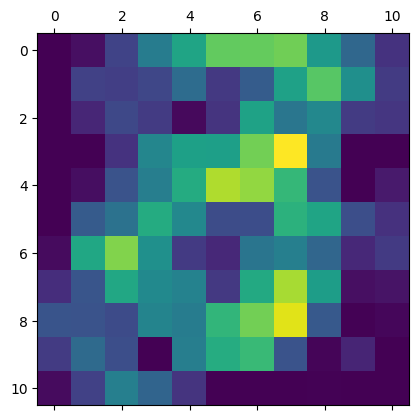

In [ ]:
heatmap = np.maximum(heatmap, 0) # => max(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Add 3 channels for coloring the heatmap
img_size = (500, 500)
# Prepare image
test_input_resized = cv2.resize(test_input.squeeze(), img_size) # (500, 500)
test_input_resized = cv2.cvtColor(test_input_resized, cv2.COLOR_GRAY2BGR) # (500, 500, 3)
test_input_resized *= 255
# Make heatmap
heatmap_resized = cv2.resize(heatmap, img_size) # (500, 500)
heatmap_resized = np.uint8(255*heatmap_resized)
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
# Apply heatmap on the original image
superimposed_img = heatmap_resized*0.5 + test_input_resized
# Save
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/output/gradcam_mnist_output.jpg', superimposed_img);

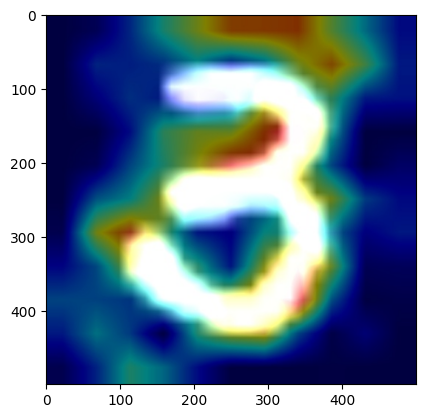

In [ ]:
img = mpimg.imread('/content/drive/MyDrive/Colab Notebooks/output/gradcam_mnist_output.jpg')
plt.imshow(img)